Loading data from mars.csv
Original shape: (72000, 3)
Shape after dropna: (72000, 3)
Final shape: (72000, 3)
Sample rate: 20.00 Hz


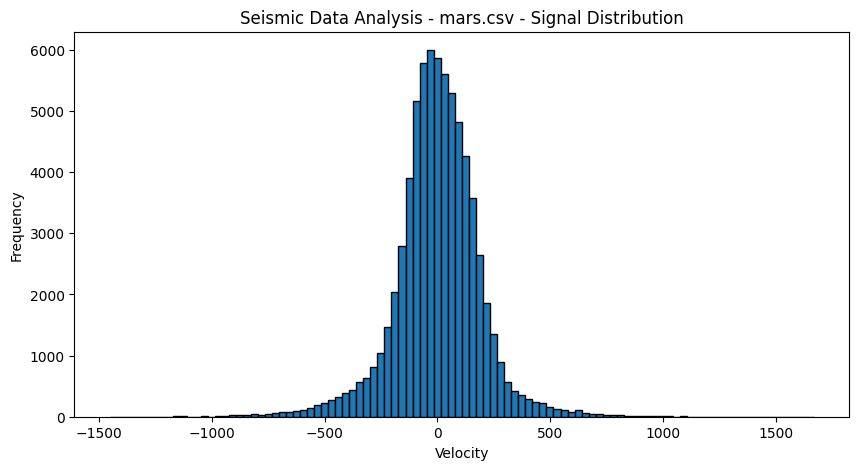

Skipped power frequency 50 Hz (higher than Nyquist frequency)
Skipped power frequency 60 Hz (higher than Nyquist frequency)
Skipped power frequency 50 Hz (higher than Nyquist frequency)
Skipped power frequency 60 Hz (higher than Nyquist frequency)


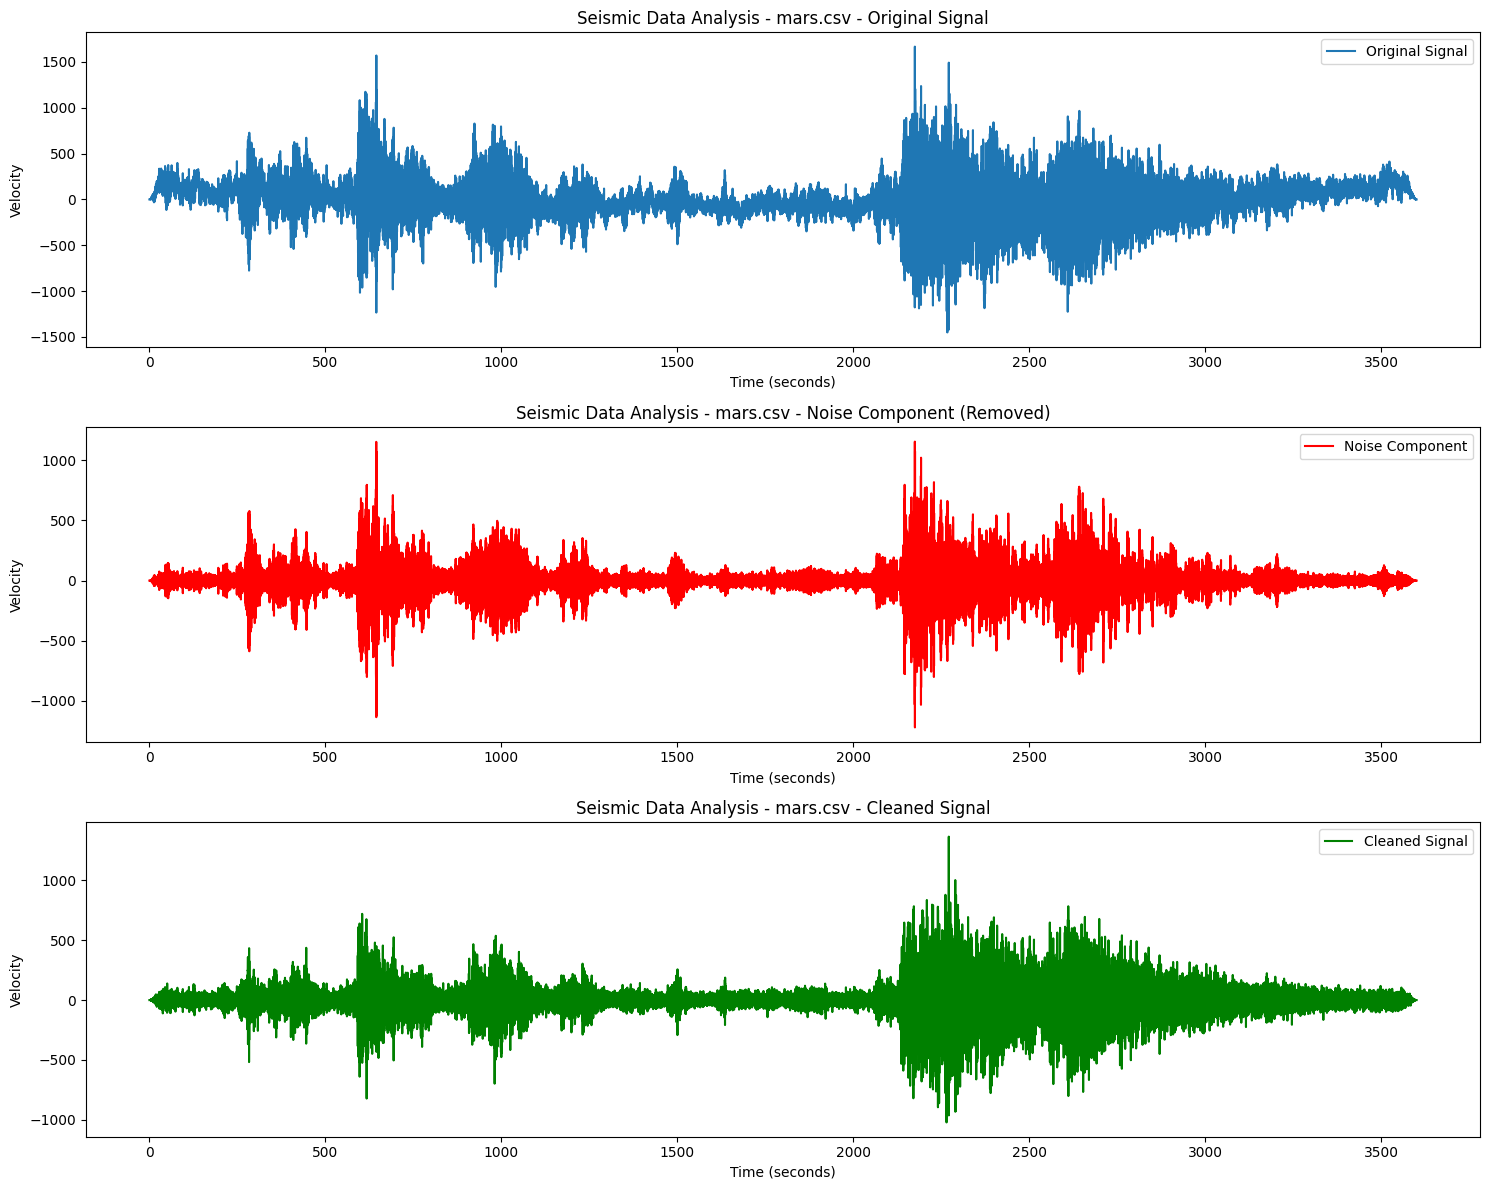

Number of detected events: 17758
Event detection threshold: 2
Signal mean: -1.7973
Signal std dev: 189.8936
Min velocity: -1451.0521
Max velocity: 1667.3123
Loading data from lunar.csv
Original shape: (136409, 3)
Shape after dropna: (136408, 3)
Final shape: (136408, 3)
Sample rate: 6.63 Hz


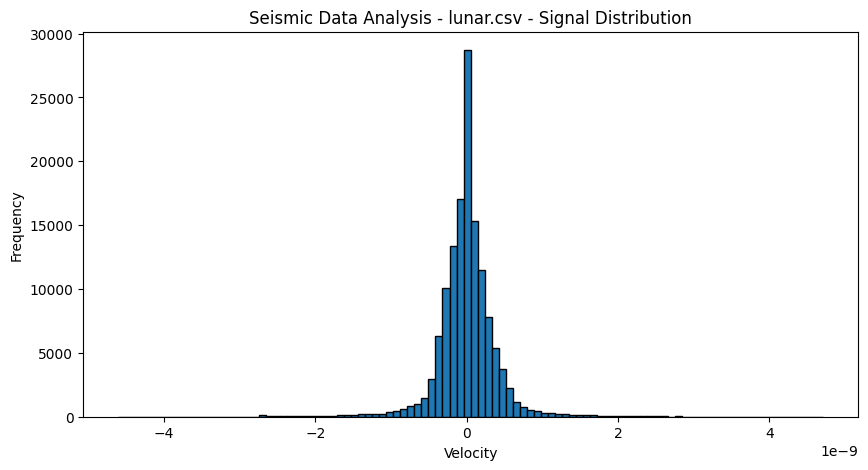

Skipped power frequency 50 Hz (higher than Nyquist frequency)
Skipped power frequency 60 Hz (higher than Nyquist frequency)
Skipped power frequency 50 Hz (higher than Nyquist frequency)
Skipped power frequency 60 Hz (higher than Nyquist frequency)


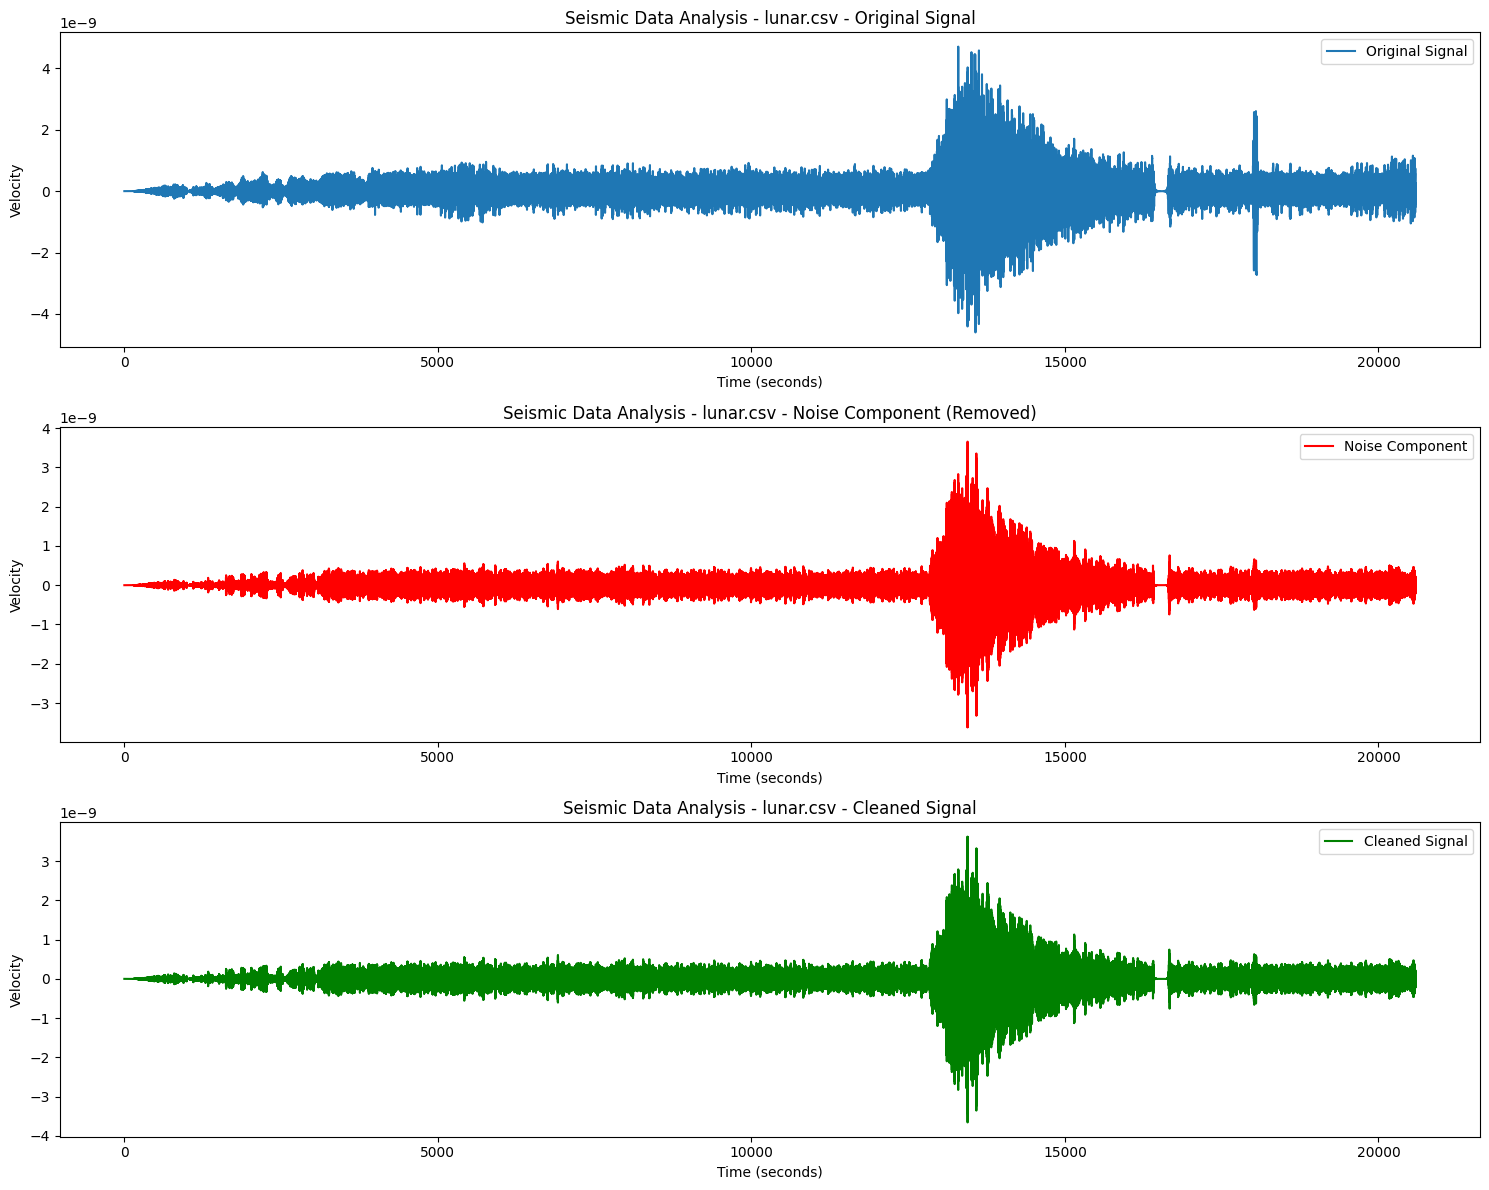

Number of detected events: 0
Event detection threshold: 2
Signal mean: -0.0000
Signal std dev: 0.0000
Min velocity: -0.0000
Max velocity: 0.0000


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import find_peaks, butter, filtfilt

def load_data(file_path, time_col, rel_time_col, velocity_col):
    df = pd.read_csv(file_path)
    print(f"Loading data from {file_path}")
    print(f"Original shape: {df.shape}")

    try:
        df[time_col] = pd.to_datetime(df[time_col], format='%Y-%m-%dT%H:%M:%S.%f')
    except ValueError:
        print("Warning: Some timestamps might be missing minutes, seconds, or fractional seconds. Attempting to parse with errors='coerce'.")
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    df = df.dropna(subset=[rel_time_col, velocity_col])
    print(f"Shape after dropna: {df.shape}")

    df = df[np.isfinite(df[velocity_col])]
    print(f"Final shape: {df.shape}")

    return df[rel_time_col].values, df[velocity_col].values

def apply_emd(signal, num_imfs=10):
    emd = EMD()
    imfs = emd(signal, max_imf=num_imfs)
    return imfs

def calculate_rms_energy(imfs):
    return np.sqrt(np.mean(imfs**2, axis=1))

def detect_events(signal, threshold):
    peaks, _ = find_peaks(np.abs(signal), height=threshold)
    return peaks

def plot_noise_reduction(time, original_signal, noise, cleaned_signal, title):
    plt.figure(figsize=(15, 12))

    plt.subplot(3, 1, 1)
    plt.plot(time, original_signal, label='Original Signal')
    plt.title(f"{title} - Original Signal")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(time, noise, label='Noise Component', color='red')
    plt.title(f"{title} - Noise Component (Removed)")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(time, cleaned_signal, label='Cleaned Signal', color='green')
    plt.title(f"{title} - Cleaned Signal")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_signal_distribution(signal, title):
    plt.figure(figsize=(10, 5))
    plt.hist(signal, bins=100, edgecolor='black')
    plt.title(f"{title} - Signal Distribution")
    plt.xlabel('Velocity')
    plt.ylabel('Frequency')
    plt.show()

def correct_baseline_wander(imfs):
    n_imfs = len(imfs)
    baseline = np.sum(imfs[n_imfs//2:], axis=0)
    return baseline

def eliminate_power_frequency(signal, fs, power_freqs=[50, 60], bandwidth=2):
    nyquist = 0.5 * fs
    cleaned_signal = signal.copy()

    for power_freq in power_freqs:
        if power_freq < nyquist:
            low = max(0.1, (power_freq - bandwidth/2)) / nyquist
            high = min(0.99, (power_freq + bandwidth/2) / nyquist)

            b, a = butter(2, [low, high], btype='bandstop')
            cleaned_signal = filtfilt(b, a, cleaned_signal)
            print(f"Eliminated power frequency: {power_freq} Hz")
        else:
            print(f"Skipped power frequency {power_freq} Hz (higher than Nyquist frequency)")

    return cleaned_signal

def process_seismic_data(file_path, time_col, rel_time_col, velocity_col, num_imfs=10, event_threshold=2, sample_rate=None):
    # Load data
    time, velocity = load_data(file_path, time_col, rel_time_col, velocity_col)

    # Calculate sample rate if not provided
    if sample_rate is None:
        sample_rate = 1 / np.mean(np.diff(time))
    print(f"Sample rate: {sample_rate:.2f} Hz")

    # Plot signal distribution
    plot_signal_distribution(velocity, f'Seismic Data Analysis - {file_path}')

    # Apply EMD
    imfs = apply_emd(velocity, num_imfs)

    # Calculate RMS energy
    rms_energy = calculate_rms_energy(imfs)

    # Baseline Wander Correction
    baseline = correct_baseline_wander(imfs)
    velocity_baseline_corrected = velocity - baseline

    # Power Frequency Elimination
    velocity_power_corrected = eliminate_power_frequency(velocity_baseline_corrected, sample_rate)

    # Separate noise (first IMF) and signal
    noise = imfs[0]
    cleaned_signal = np.sum(imfs[1:], axis=0) - baseline

    # Apply power frequency elimination to cleaned signal
    cleaned_signal = eliminate_power_frequency(cleaned_signal, sample_rate)

    # Plot noise reduction
    plot_noise_reduction(time, velocity, noise, cleaned_signal, f'Seismic Data Analysis - {file_path}')

    # Detect events
    events = detect_events(cleaned_signal, event_threshold)

    print(f"Number of detected events: {len(events)}")
    print(f"Event detection threshold: {event_threshold}")
    print(f"Signal mean: {np.mean(velocity):.4f}")
    print(f"Signal std dev: {np.std(velocity):.4f}")
    print(f"Min velocity: {np.min(velocity):.4f}")
    print(f"Max velocity: {np.max(velocity):.4f}")

    return cleaned_signal, events

# Process Mars data
mars_file = 'mars.csv'
mars_cleaned, mars_events = process_seismic_data(mars_file, 'time(%Y-%m-%dT%H:%M:%S.%f)', 'rel_time(sec)', 'velocity(c/s)')

# Process Lunar data
lunar_file = 'lunar.csv'
lunar_cleaned, lunar_events = process_seismic_data(lunar_file, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'velocity(m/s)')

Loading data from mars.csv
Original shape: (72000, 3)
Shape after dropna: (72000, 3)
Final shape: (72000, 3)
Sample rate: 20.00 Hz


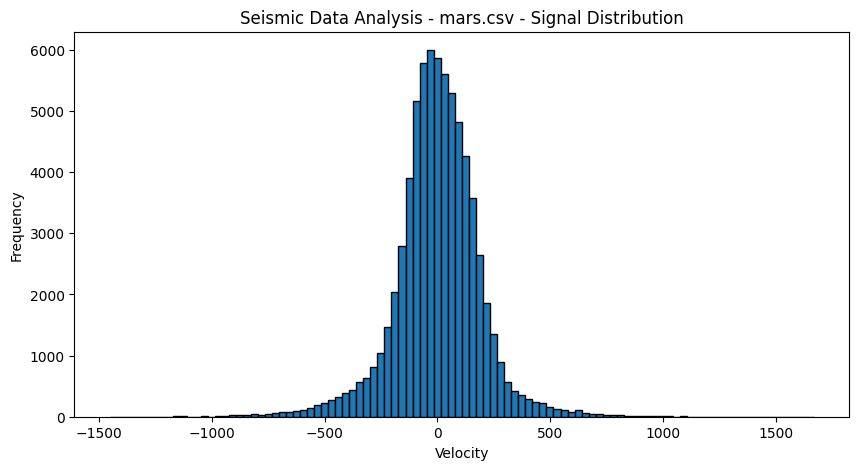

Skipped power frequency 50 Hz (higher than Nyquist frequency)
Skipped power frequency 60 Hz (higher than Nyquist frequency)
Skipped power frequency 50 Hz (higher than Nyquist frequency)
Skipped power frequency 60 Hz (higher than Nyquist frequency)


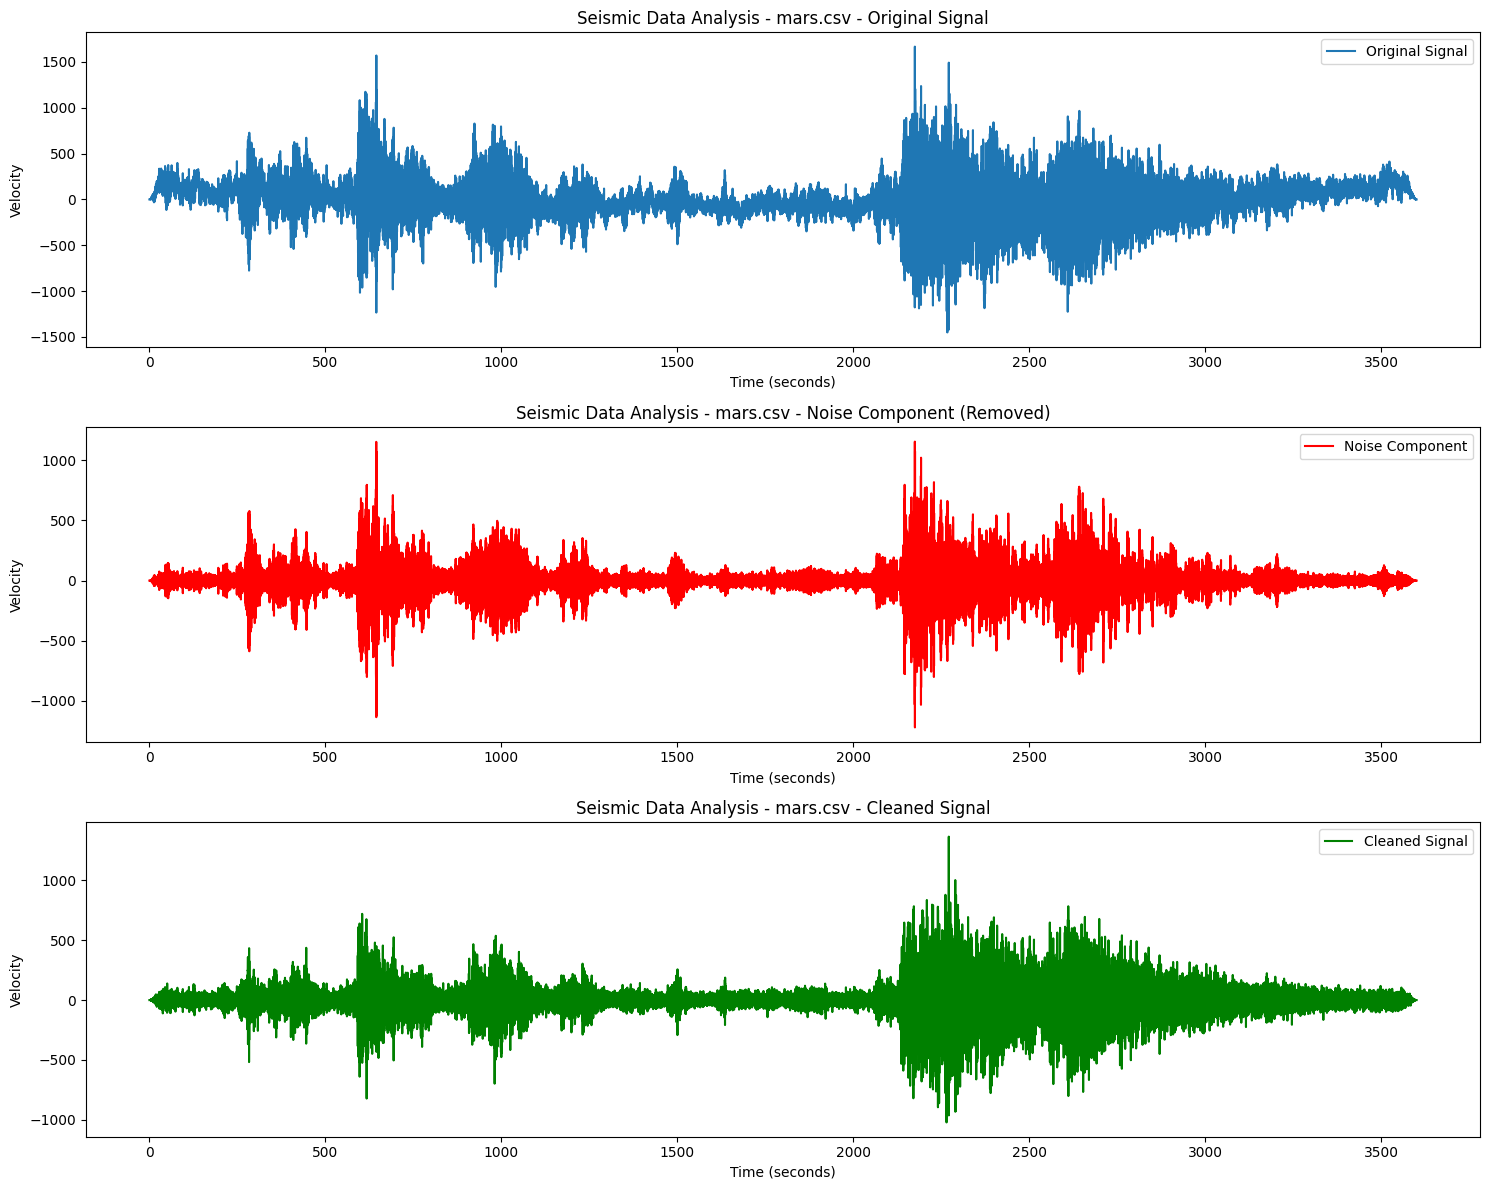

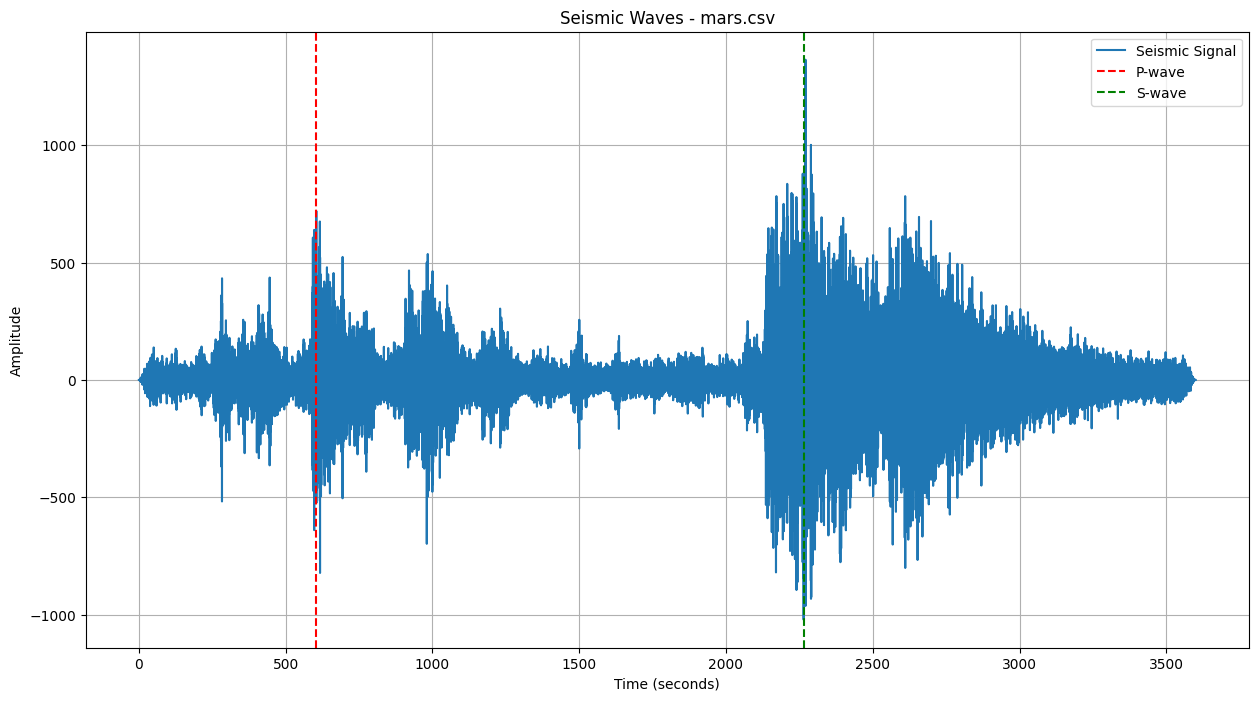

Number of detected events: 17758
Event detection threshold: 2
Signal mean: -1.7973
Signal std dev: 189.8936
Min velocity: -1451.0521
Max velocity: 1667.3123
Estimated P-wave arrival time: 604.45 seconds
Estimated S-wave arrival time: 2264.50 seconds
Loading data from lunar.csv
Original shape: (136409, 3)
Shape after dropna: (136408, 3)
Final shape: (136408, 3)
Sample rate: 6.63 Hz


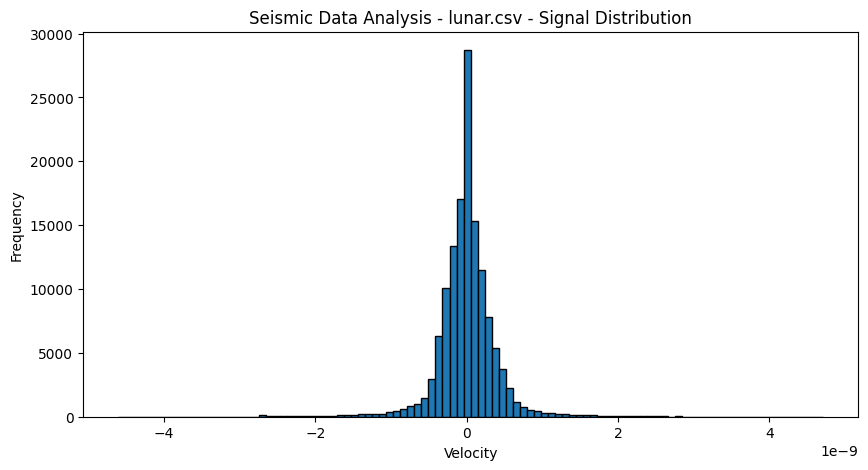

Skipped power frequency 50 Hz (higher than Nyquist frequency)
Skipped power frequency 60 Hz (higher than Nyquist frequency)
Skipped power frequency 50 Hz (higher than Nyquist frequency)
Skipped power frequency 60 Hz (higher than Nyquist frequency)


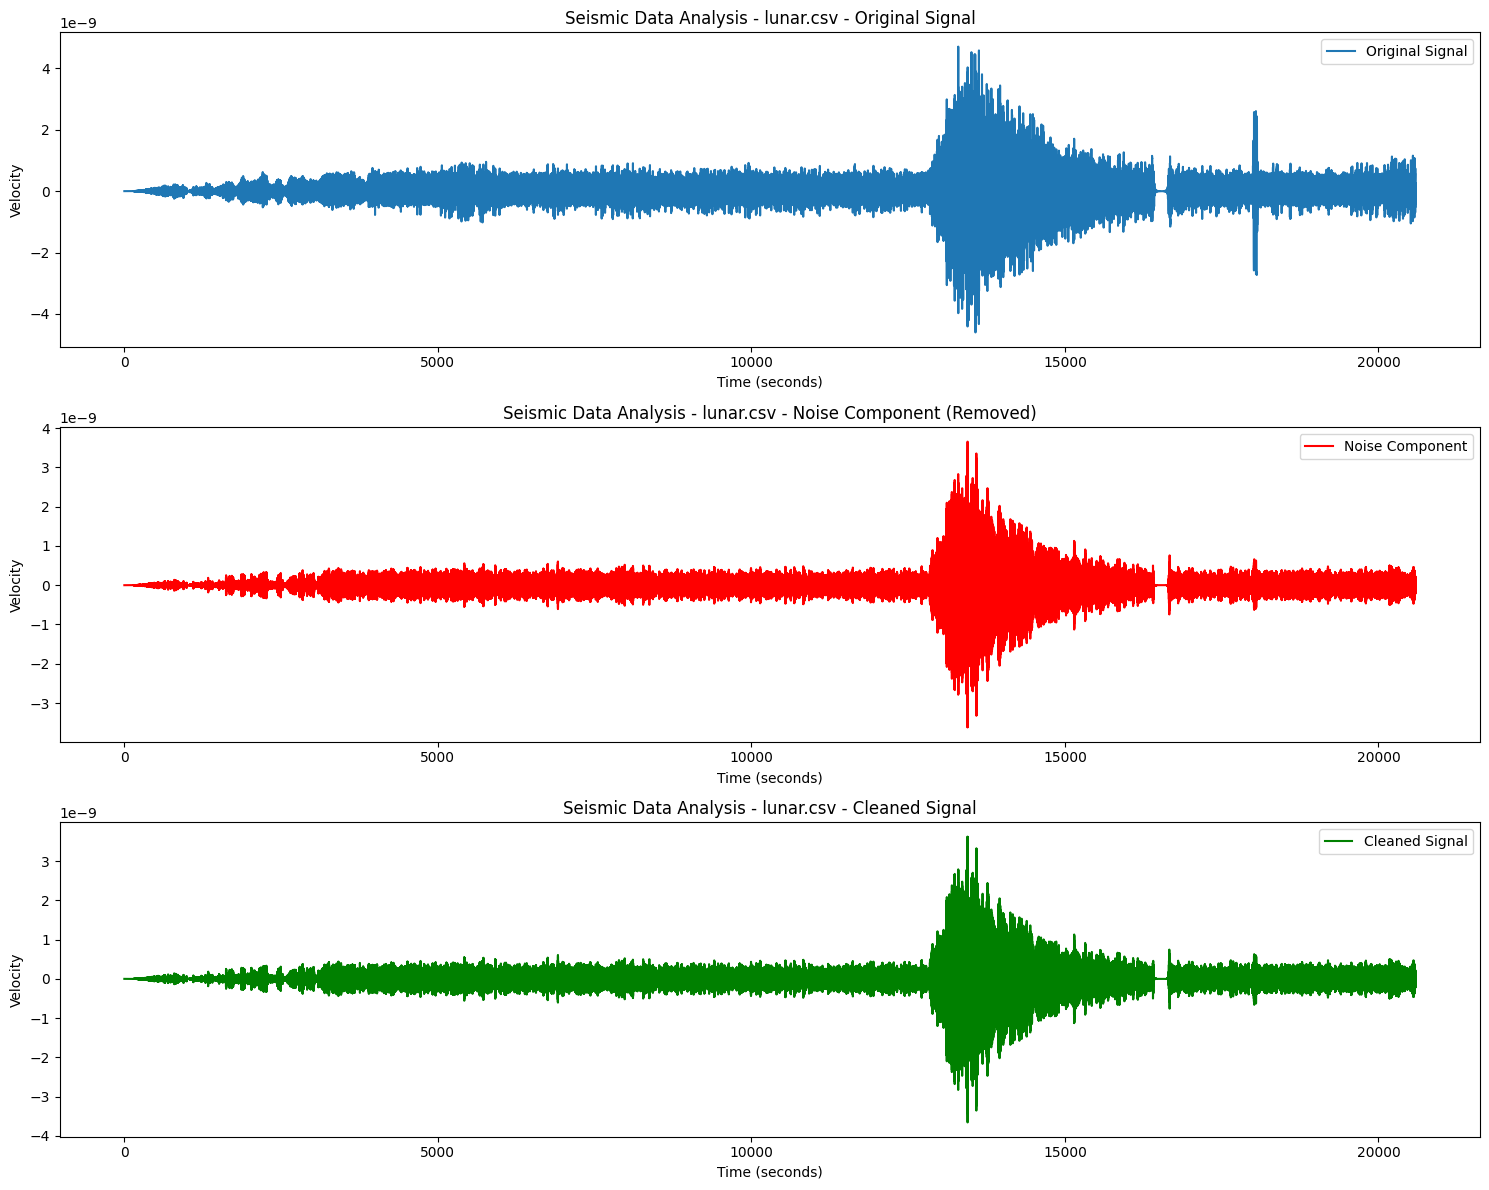

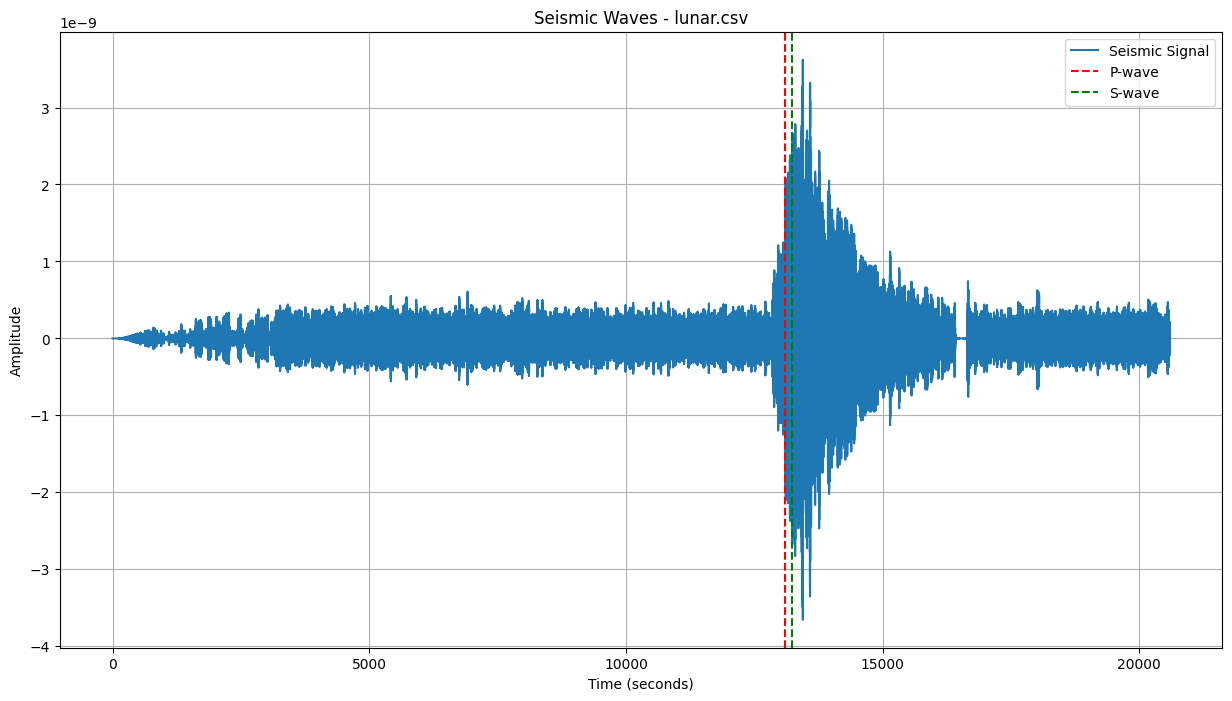

Number of detected events: 0
Event detection threshold: 2
Signal mean: -0.0000
Signal std dev: 0.0000
Min velocity: -0.0000
Max velocity: 0.0000
Estimated P-wave arrival time: 13106.42 seconds
Estimated S-wave arrival time: 13240.75 seconds


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
from scipy.signal import find_peaks, butter, filtfilt

def load_data(file_path, time_col, rel_time_col, velocity_col):
    df = pd.read_csv(file_path)
    print(f"Loading data from {file_path}")
    print(f"Original shape: {df.shape}")

    try:
        df[time_col] = pd.to_datetime(df[time_col], format='%Y-%m-%dT%H:%M:%S.%f')
    except ValueError:
        print("Warning: Some timestamps might be missing minutes, seconds, or fractional seconds. Attempting to parse with errors='coerce'.")
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    df = df.dropna(subset=[rel_time_col, velocity_col])
    print(f"Shape after dropna: {df.shape}")

    df = df[np.isfinite(df[velocity_col])]
    print(f"Final shape: {df.shape}")

    return df[rel_time_col].values, df[velocity_col].values

def apply_emd(signal, num_imfs=10):
    emd = EMD()
    imfs = emd(signal, max_imf=num_imfs)
    return imfs

def calculate_rms_energy(imfs):
    return np.sqrt(np.mean(imfs**2, axis=1))

def detect_events(signal, threshold):
    peaks, _ = find_peaks(np.abs(signal), height=threshold)
    return peaks

def plot_noise_reduction(time, original_signal, noise, cleaned_signal, title):
    plt.figure(figsize=(15, 12))

    plt.subplot(3, 1, 1)
    plt.plot(time, original_signal, label='Original Signal')
    plt.title(f"{title} - Original Signal")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(time, noise, label='Noise Component', color='red')
    plt.title(f"{title} - Noise Component (Removed)")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(time, cleaned_signal, label='Cleaned Signal', color='green')
    plt.title(f"{title} - Cleaned Signal")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_signal_distribution(signal, title):
    plt.figure(figsize=(10, 5))
    plt.hist(signal, bins=100, edgecolor='black')
    plt.title(f"{title} - Signal Distribution")
    plt.xlabel('Velocity')
    plt.ylabel('Frequency')
    plt.show()

def correct_baseline_wander(imfs):
    n_imfs = len(imfs)
    baseline = np.sum(imfs[n_imfs//2:], axis=0)
    return baseline

def eliminate_power_frequency(signal, fs, power_freqs=[50, 60], bandwidth=2):
    nyquist = 0.5 * fs
    cleaned_signal = signal.copy()

    for power_freq in power_freqs:
        if power_freq < nyquist:
            low = max(0.1, (power_freq - bandwidth/2)) / nyquist
            high = min(0.99, (power_freq + bandwidth/2)) / nyquist

            b, a = butter(2, [low, high], btype='bandstop')
            cleaned_signal = filtfilt(b, a, cleaned_signal)
            print(f"Eliminated power frequency: {power_freq} Hz")
        else:
            print(f"Skipped power frequency {power_freq} Hz (higher than Nyquist frequency)")

    return cleaned_signal

def detect_p_s_waves(signal, time, p_threshold=0.5, s_threshold=0.7):
    abs_signal = np.abs(signal)
    max_amplitude = np.max(abs_signal)

    p_wave_index = np.where(abs_signal > p_threshold * max_amplitude)[0][0]
    s_wave_index = np.where(abs_signal > s_threshold * max_amplitude)[0][0]

    return time[p_wave_index], time[s_wave_index]

def plot_seismic_waves(time, signal, p_wave_time, s_wave_time, title):
    plt.figure(figsize=(15, 8))
    plt.plot(time, signal, label='Seismic Signal')
    plt.axvline(p_wave_time, color='r', linestyle='--', label='P-wave')
    plt.axvline(s_wave_time, color='g', linestyle='--', label='S-wave')
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

def process_seismic_data(file_path, time_col, rel_time_col, velocity_col, num_imfs=10, event_threshold=2, sample_rate=None):
    # Load data
    time, velocity = load_data(file_path, time_col, rel_time_col, velocity_col)

    # Calculate sample rate if not provided
    if sample_rate is None:
        sample_rate = 1 / np.mean(np.diff(time))
    print(f"Sample rate: {sample_rate:.2f} Hz")

    # Plot signal distribution
    plot_signal_distribution(velocity, f'Seismic Data Analysis - {file_path}')

    # Apply EMD
    imfs = apply_emd(velocity, num_imfs)

    # Calculate RMS energy
    rms_energy = calculate_rms_energy(imfs)

    # Baseline Wander Correction
    baseline = correct_baseline_wander(imfs)
    velocity_baseline_corrected = velocity - baseline

    # Power Frequency Elimination
    velocity_power_corrected = eliminate_power_frequency(velocity_baseline_corrected, sample_rate)

    # Separate noise (first IMF) and signal
    noise = imfs[0]
    cleaned_signal = np.sum(imfs[1:], axis=0) - baseline

    # Apply power frequency elimination to cleaned signal
    cleaned_signal = eliminate_power_frequency(cleaned_signal, sample_rate)

    # Plot noise reduction
    plot_noise_reduction(time, velocity, noise, cleaned_signal, f'Seismic Data Analysis - {file_path}')

    # Detect events
    events = detect_events(cleaned_signal, event_threshold)

    # Detect P-waves and S-waves
    p_wave_time, s_wave_time = detect_p_s_waves(cleaned_signal, time)

    # Plot seismic waves with P-wave and S-wave annotations
    plot_seismic_waves(time, cleaned_signal, p_wave_time, s_wave_time, f'Seismic Waves - {file_path}')

    print(f"Number of detected events: {len(events)}")
    print(f"Event detection threshold: {event_threshold}")
    print(f"Signal mean: {np.mean(velocity):.4f}")
    print(f"Signal std dev: {np.std(velocity):.4f}")
    print(f"Min velocity: {np.min(velocity):.4f}")
    print(f"Max velocity: {np.max(velocity):.4f}")
    print(f"Estimated P-wave arrival time: {p_wave_time:.2f} seconds")
    print(f"Estimated S-wave arrival time: {s_wave_time:.2f} seconds")

    return cleaned_signal, events, p_wave_time, s_wave_time

# Process Mars data
mars_file = 'mars.csv'
mars_cleaned, mars_events, mars_p_wave, mars_s_wave = process_seismic_data(
    mars_file,
    'time(%Y-%m-%dT%H:%M:%S.%f)',
    'rel_time(sec)',
    'velocity(c/s)'
)

# Process Lunar data
lunar_file = 'lunar.csv'
lunar_cleaned, lunar_events, lunar_p_wave, lunar_s_wave = process_seismic_data(
    lunar_file,
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)',
    'time_rel(sec)',
    'velocity(m/s)'
)